# Pakistan Sign Language (PSL) Recognition

### Install and import required modules

In [ ]:
!pip install keras tensorflow scikit-learn

In [26]:
import keras
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg19 import VGG19
from keras.models import Model
from keras.preprocessing import image
from tensorflow.keras.layers import Input, Lambda ,Dense ,Flatten ,Dropout
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2

## Loading Images

In [27]:
#Helper function to load images from given directories
def load_images(directory, uniq_labels):
    images = []
    labels = []
    for idx, label in enumerate(uniq_labels):
        for file in os.listdir(directory + "/" + label):
            filepath = directory + "/" + label + "/" + file
            img = cv2.imdecode(np.fromfile(filepath, dtype=np.uint8), cv2.IMREAD_UNCHANGED)
            image = cv2.resize(img, (64, 64))
            images.append(image)
            labels.append(idx)
    images = np.array(images)
    labels = np.array(labels)
    return(images, labels)

In [28]:
train_dir = "PSL"

uniq_labels = sorted(os.listdir(train_dir))
images, labels = load_images(train_dir, uniq_labels)

## Train Test Split

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size = 0.2, stratify = labels)

n = len(uniq_labels)
train_n = len(X_train)
test_n = len(X_test)

print("Total number of symbols: ", n)
print("Number of training images: " , train_n)
print("Number of testing images: ", test_n)

Total number of symbols:  37
Number of training images:  1207
Number of testing images:  302


In [30]:
uniq_labels

['Ain ع',
 'Aliph ا',
 'Bari yeh ے',
 'Bay ب',
 'Chay چ',
 'Chhoti yeh ی',
 'Daal  د',
 'Daal ڈ',
 'Dhaal ذ',
 'Dhuaad ض',
 'Djay ژ',
 'Fay ف',
 'Gaaf گ',
 'Ghain غ',
 'Hamza \u200d\u200cء',
 'Hay ہ',
 'Jeem ج',
 'Kaaf ک',
 'Khay خ',
 'Laam ل',
 'Meem م',
 'Noon ن',
 'Pay پ',
 'Quaaf ق',
 'Ray ر',
 'Seen س',
 'Sheen \u200e\u200eش',
 'Suaad ص',
 'Tay ت',
 'Tey ٹ',
 'Thay ث',
 "Toay'n ط",
 'Vao و',
 'Zay ز',
 "Zoay'n ظ",
 'aRay ڑ',
 'hey ح']

## Preprocessing

### One-hot Encoding

In [31]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

### Normalization

In [33]:
X_train = X_train.astype('float32')/255.0
X_test = X_test.astype('float32')/255.0

## Model Initialization

### VGG16

In [34]:
classifier_vgg16 = VGG16(input_shape= (64,64,3),include_top=False,weights='imagenet')

### Resnet

In [35]:
classifier_resnet = ResNet50(input_shape= (64,64,3),include_top=False,weights='imagenet')

## Model Tuning

In [36]:
#don't train existing weights for vgg16
for layer in classifier_vgg16.layers:
    layer.trainable = False

#don't train existing weights for resnet50
for layer in classifier_resnet.layers:
    layer.trainable = False

In [37]:
classifier1 = classifier_vgg16.output#head mode
classifier1 = Flatten()(classifier1)#adding layer of flatten
classifier1 = Dense(units=256, activation='relu')(classifier1)
classifier1 = Dropout(0.6)(classifier1)
classifier1 = Dense(units=37, activation='softmax')(classifier1)

model = Model(inputs = classifier_vgg16.input , outputs = classifier1)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [38]:
classifier2 = classifier_resnet.output#head mode
classifier2 = Flatten()(classifier2)#adding layer of flatten
classifier2 = Dropout(0.6)(classifier2)
classifier2 = Dense(units=37, activation='softmax')(classifier2)

model2 = Model(inputs = classifier_resnet.input , outputs = classifier2)
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [39]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0   

In [40]:
model2.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 70, 70, 3)            0         ['input_4[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 32, 32, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 32, 32, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                        

## Model Training

### VGG16

In [41]:
history = model.fit(X_train, y_train, epochs=50, batch_size = 64,validation_data=(X_test,y_test))

Epoch 1/50
19/19 [==============================] - 45s 2s/step - loss: 3.2970 - accuracy: 0.1624 - val_loss: 2.5254 - val_accuracy: 0.6755
Epoch 2/50
19/19 [==============================] - 34s 2s/step - loss: 2.2950 - accuracy: 0.4316 - val_loss: 1.6020 - val_accuracy: 0.8278
Epoch 3/50
19/19 [==============================] - 36s 2s/step - loss: 1.6315 - accuracy: 0.6065 - val_loss: 1.0255 - val_accuracy: 0.9007
Epoch 4/50
19/19 [==============================] - 63s 3s/step - loss: 1.1685 - accuracy: 0.7415 - val_loss: 0.7017 - val_accuracy: 0.9238
Epoch 5/50
19/19 [==============================] - 60s 3s/step - loss: 0.8962 - accuracy: 0.7929 - val_loss: 0.5129 - val_accuracy: 0.9371
Epoch 6/50
19/19 [==============================] - 68s 4s/step - loss: 0.6923 - accuracy: 0.8393 - val_loss: 0.4094 - val_accuracy: 0.9437
Epoch 7/50
19/19 [==============================] - 71s 4s/step - loss: 0.5753 - accuracy: 0.8749 - val_loss: 0.3307 - val_accuracy: 0.9470
Epoch 8/50
19/19 [==

### Resnet

In [42]:
history2 = model2.fit(X_train, y_train, epochs =50, batch_size = 64,validation_data=(X_test,y_test))

Epoch 1/50
19/19 [==============================] - 28s 1s/step - loss: 3.8789 - accuracy: 0.0323 - val_loss: 3.3687 - val_accuracy: 0.1656
Epoch 2/50
19/19 [==============================] - 20s 1s/step - loss: 3.5124 - accuracy: 0.0812 - val_loss: 3.0772 - val_accuracy: 0.3874
Epoch 3/50
19/19 [==============================] - 19s 1s/step - loss: 3.1875 - accuracy: 0.1334 - val_loss: 2.8636 - val_accuracy: 0.4669
Epoch 4/50
19/19 [==============================] - 24s 1s/step - loss: 2.9517 - accuracy: 0.2038 - val_loss: 2.6864 - val_accuracy: 0.4868
Epoch 5/50
19/19 [==============================] - 29s 2s/step - loss: 2.8010 - accuracy: 0.2577 - val_loss: 2.5314 - val_accuracy: 0.6192
Epoch 6/50
19/19 [==============================] - 31s 2s/step - loss: 2.6397 - accuracy: 0.2850 - val_loss: 2.4029 - val_accuracy: 0.6126
Epoch 7/50
19/19 [==============================] - 28s 1s/step - loss: 2.4908 - accuracy: 0.3455 - val_loss: 2.2898 - val_accuracy: 0.6656
Epoch 8/50
19/19 [==

## Save Models

In [43]:
model.save('model_vgg16.h5')
model2.save('model_resnet.h5')

c:\Users\Dell\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Model Performance

Accuracy of **VGG16**

In [44]:
score = model.evaluate(x = X_test, y = y_test, verbose = 0)
print('Accuracy for test images:', round(score[1]*100, 3), '%')

Accuracy for test images: 97.351 %


Accuracy of **RESNET50**

In [45]:
score = model2.evaluate(x = X_test, y = y_test, verbose = 0)
print('Accuracy for test images:', round(score[1]*100, 3), '%')

Accuracy for test images: 79.801 %


## Accuracy and Loss Plot

### VGG16

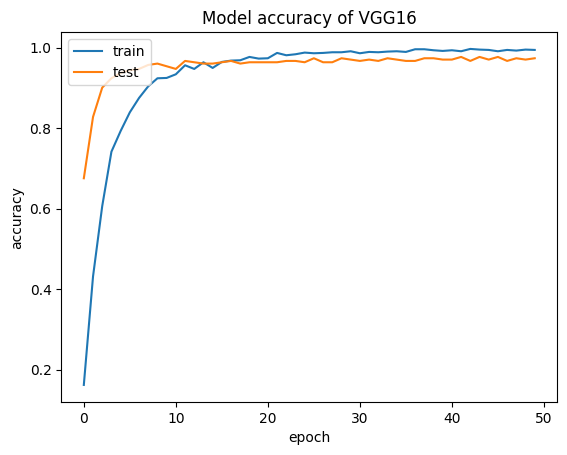

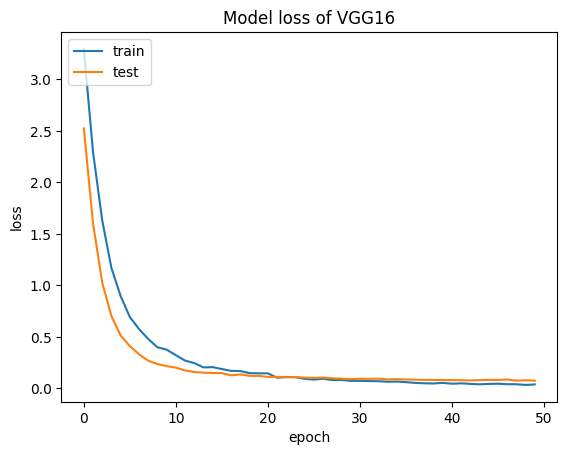

In [48]:
import matplotlib.pyplot as plt


plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy of VGG16')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss of VGG16')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Resnet

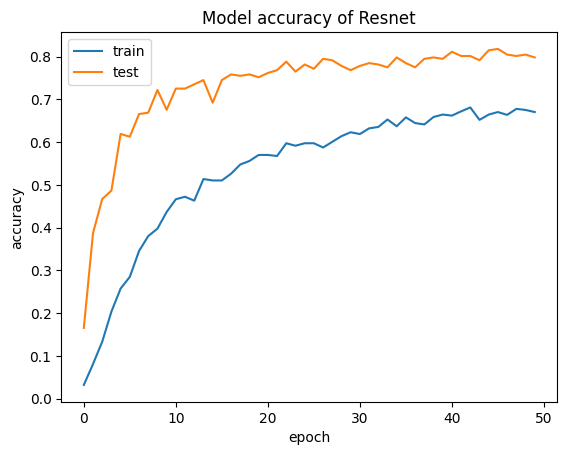

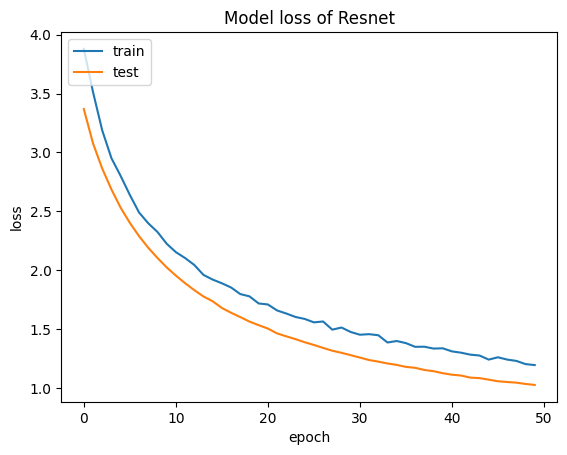

In [49]:

import matplotlib.pyplot as plt


plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model accuracy of Resnet')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss of Resnet')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()